# TCGA PANCAN Integrated Dataset Creation

This notebook creates integrated datasets for the Cancer Foundation Model by combining multi-omics data with Cox regression coefficients.

## Architecture Overview:
1. **TabTransformer Model 1**: Clinical + Expression + CNV + miRNA + RPPA + Mutations (with Cox coefficients)
2. **TabTransformer Model 2**: Methylation data (separate, no Cox coefficients)
3. **SwinTransformer Model**: WSI patches (future implementation)

## Key Features:
- [measured_value, cox_coefficient] pairs for numerical omics features
- Wide format table with patients as rows, features as columns
- Separate handling of methylation data for dedicated TabTransformer
- PyTorch Dataset classes for flexible model training
- Train/validation/test splits with stratification by cancer type

## Expected Outputs:
- `integrated_table_cox.parquet`: Cox-enhanced omics + clinical data
- `methylation_table.parquet`: Methylation-only data
- `src/preprocessing/integrated_dataset.py`: PyTorch Dataset classes
- `train_val_test_splits.json`: Data split indices

## 1. Environment Setup and Library Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
from collections import defaultdict
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

# Define paths
DATA_RAW_PATH = Path('../data/raw')
DATA_PROCESSED_PATH = Path('../data/processed')
RESULTS_PATH = Path('../results')
SRC_PATH = Path('../src')
PREPROCESSING_PATH = SRC_PATH / 'preprocessing'

# Create directories if they don't exist
PREPROCESSING_PATH.mkdir(parents=True, exist_ok=True)

print("Environment setup complete!")
print(f"Data processed path: {DATA_PROCESSED_PATH}")
print(f"Results path: {RESULTS_PATH}")
print(f"Source path: {SRC_PATH}")
print(f"PyTorch version: {torch.__version__}")

Environment setup complete!
Data processed path: ../data/processed
Results path: ../results
Source path: ../src
PyTorch version: 2.8.0+cu128


## 1.1. Generate Clinical Data for Methylation Analysis

In [7]:
# 메틸레이션 데이터는 Cox 분석없이 따로 Transformer 모델로 학습하기 위해 따로 임상데이터 테이블을 구축함.

print("=" * 60)
print("GENERATING CLINICAL DATA FOR METHYLATION ANALYSIS")
print("=" * 60)

# Load existing methylation data to get patient list
print("\n📊 Loading existing methylation data to extract patient list...")

methylation_file = DATA_PROCESSED_PATH / 'methylation_data_for_tabtransformer.parquet'
if methylation_file.exists():
    methylation_data_existing = pd.read_parquet(methylation_file)
    methylation_patient_ids = list(methylation_data_existing.index)
    print(f"  🧬 Methylation data patients: {len(methylation_patient_ids):,}")
    print(f"  📊 Methylation data shape: {methylation_data_existing.shape}")
    
    # Load raw clinical data
    print("\n📋 Loading raw clinical data...")
    raw_clinical_file = DATA_RAW_PATH / 'clinical_PANCAN_patient_with_followup.tsv'
    
    if raw_clinical_file.exists():
        # Load with different encodings to handle problematic characters
        encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
        
        raw_clinical_data = None
        for encoding in encodings_to_try:
            try:
                raw_clinical_data = pd.read_csv(raw_clinical_file, sep='\t', encoding=encoding, low_memory=False)
                print(f"  ✅ Loaded with {encoding} encoding")
                break
            except UnicodeDecodeError:
                continue
        
        if raw_clinical_data is None:
            # Last resort: ignore problematic characters
            raw_clinical_data = pd.read_csv(raw_clinical_file, sep='\t', encoding='utf-8', errors='ignore', low_memory=False)
            print(f"  ⚠️  Loaded with UTF-8 encoding, ignoring problematic characters")
        
        print(f"  📊 Raw clinical data: {raw_clinical_data.shape[0]} patients × {raw_clinical_data.shape[1]} features")
        
        # Standardize patient IDs
        def standardize_patient_id(patient_id):
            if isinstance(patient_id, str):
                parts = patient_id.split('-')
                if len(parts) >= 3:
                    return f"{parts[0]}-{parts[1]}-{parts[2]}"
            return patient_id
        
        raw_clinical_data['bcr_patient_barcode'] = raw_clinical_data['bcr_patient_barcode'].apply(standardize_patient_id)
        raw_clinical_data = raw_clinical_data.set_index('bcr_patient_barcode')
        
        # Extract clinical data for methylation patients only
        print(f"\n🎯 Extracting clinical data for {len(methylation_patient_ids):,} methylation patients...")
        
        # Find intersection of methylation patients and clinical patients
        common_patients = list(set(methylation_patient_ids).intersection(set(raw_clinical_data.index)))
        print(f"  🤝 Common patients (methylation + clinical): {len(common_patients):,}")
        
        if len(common_patients) > 0:
            # Extract clinical data for common patients
            clinical_for_methylation = raw_clinical_data.loc[common_patients].copy()
            
            # Clean survival data function (same as in previous notebook)
            def clean_survival_data_for_methylation(clinical_df):
                print("  🔧 Cleaning survival data for methylation patients...")
                
                clinical_clean = clinical_df.copy()
                
                # 1. days_to_death 정리
                death_col = clinical_clean['days_to_death'].copy()
                invalid_death = death_col.isin(['[Not Applicable]', '[Not Available]', '[Discrepancy]', '[Unknown]'])
                death_col[invalid_death] = np.nan
                death_col = pd.to_numeric(death_col, errors='coerce')
                clinical_clean['days_to_death_clean'] = death_col
                
                # 2. days_to_last_followup 정리
                followup_col = clinical_clean['days_to_last_followup'].copy()
                invalid_followup = followup_col.isin(['[Not Applicable]', '[Not Available]', '[Discrepancy]', '[Unknown]'])
                followup_col[invalid_followup] = np.nan
                followup_col = pd.to_numeric(followup_col, errors='coerce')
                
                # 음수값 제거
                negative_followup = followup_col < 0
                followup_col[negative_followup] = np.nan
                clinical_clean['days_to_last_followup_clean'] = followup_col
                
                # 3. vital_status 정리
                valid_vital_status = clinical_clean['vital_status'].isin(['Alive', 'Dead'])
                
                # 4. 새로운 생존 시간과 이벤트 생성
                survival_time_new = np.where(
                    (clinical_clean['vital_status'] == 'Dead') & clinical_clean['days_to_death_clean'].notna(),
                    clinical_clean['days_to_death_clean'],
                    clinical_clean['days_to_last_followup_clean']
                )
                
                survival_event_new = (clinical_clean['vital_status'] == 'Dead').astype(int)
                survival_event_new[~valid_vital_status] = np.nan
                survival_time_new[~valid_vital_status] = np.nan
                
                clinical_clean['survival_time_clean'] = survival_time_new
                clinical_clean['survival_event_clean'] = survival_event_new
                
                # 5. 유효한 생존 데이터만 남기기
                valid_survival = (
                    pd.notna(clinical_clean['survival_time_clean']) & 
                    pd.notna(clinical_clean['survival_event_clean']) &
                    (clinical_clean['survival_time_clean'] >= 0)
                )
                
                return clinical_clean, valid_survival
            
            # Clean survival data
            clinical_data_cleaned, valid_survival_mask = clean_survival_data_for_methylation(clinical_for_methylation)
            
            print(f"    📊 Patients with valid survival data: {valid_survival_mask.sum():,}")
            print(f"    💀 Death events: {clinical_data_cleaned.loc[valid_survival_mask, 'survival_event_clean'].sum():.0f}")
            print(f"    📅 Mean survival time: {clinical_data_cleaned.loc[valid_survival_mask, 'survival_time_clean'].mean():.1f} days")
            
            # Filter for valid survival data
            clinical_methylation_final = clinical_data_cleaned.loc[valid_survival_mask].copy()
            
            # Save processed clinical data for methylation
            methylation_clinical_file = DATA_PROCESSED_PATH / 'processed_clinical_data_for_methylation.parquet'
            clinical_methylation_final.to_parquet(methylation_clinical_file)
            
            print(f"\n✅ Clinical data for methylation analysis saved: {methylation_clinical_file}")
            print(f"   📊 Shape: {clinical_methylation_final.shape}")
            print(f"   💾 Size: {methylation_clinical_file.stat().st_size / 1024**2:.1f} MB")
            
            # Display cancer type distribution
            if 'acronym' in clinical_methylation_final.columns:
                cancer_dist = clinical_methylation_final['acronym'].value_counts()
                print(f"\n🧬 Cancer types in methylation clinical data: {len(cancer_dist)}")
                print(f"   📋 All cancer types: {sorted(cancer_dist.index.tolist())}")
                print(f"   🔝 Top 10: {dict(cancer_dist.head(10))}")
            
            # Update global variable for downstream use
            final_methylation_patients = list(clinical_methylation_final.index)
            
        else:
            print("  ❌ No common patients found between methylation and clinical data")
            clinical_methylation_final = pd.DataFrame()
            final_methylation_patients = []
    
    else:
        print(f"❌ Raw clinical file not found: {raw_clinical_file}")
        clinical_methylation_final = pd.DataFrame()
        final_methylation_patients = []

else:
    print(f"❌ Methylation data file not found: {methylation_file}")
    clinical_methylation_final = pd.DataFrame()
    final_methylation_patients = []

print(f"\n📋 Clinical data preparation completed!")
print(f"   Cox analysis patients: 4,504 (existing processed_clinical_data.parquet)")
print(f"   Methylation patients: {len(clinical_methylation_final):,} (new processed_clinical_data_for_methylation.parquet)")
print(f"   📊 Final methylation dataset will use {len(final_methylation_patients) if 'final_methylation_patients' in locals() else 0:,} patients")

GENERATING CLINICAL DATA FOR METHYLATION ANALYSIS

📊 Loading existing methylation data to extract patient list...
  🧬 Methylation data patients: 8,224
  📊 Methylation data shape: (8224, 396065)

📋 Loading raw clinical data...
  ✅ Loaded with latin-1 encoding
  📊 Raw clinical data: 10956 patients × 746 features

🎯 Extracting clinical data for 8,224 methylation patients...
  🤝 Common patients (methylation + clinical): 8,224
  🔧 Cleaning survival data for methylation patients...
    📊 Patients with valid survival data: 8,224
    💀 Death events: 2219
    📅 Mean survival time: 1001.0 days

✅ Clinical data for methylation analysis saved: ../data/processed/processed_clinical_data_for_methylation.parquet
   📊 Shape: (8224, 749)
   💾 Size: 1.9 MB

🧬 Cancer types in methylation clinical data: 32
   📋 All cancer types: ['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 

## 2. Load Previous Results and Data

In [8]:
print("=" * 60)
print("LOADING PREVIOUS PROCESSING RESULTS")
print("=" * 60)

# Load processed omics data
print("\n📊 Loading processed omics data...")
omics_data = {}

# Load Cox-enhanced omics data (log2 transformed)
omics_files = {
    'Expression': 'processed_expression_data.parquet',
    'CNV': 'processed_cnv_data.parquet', 
    'microRNA': 'processed_microrna_data.parquet',
    'RPPA': 'processed_rppa_data.parquet',
    'Mutations': 'processed_mutations_data.parquet'
}

for omics_type, filename in omics_files.items():
    file_path = DATA_PROCESSED_PATH / filename
    if file_path.exists():
        data = pd.read_parquet(file_path)
        omics_data[omics_type] = data
        print(f"  ✅ {omics_type}: {data.shape[0]} patients × {data.shape[1]} features")
    else:
        print(f"  ❌ {omics_type}: File not found - {filename}")

# Load methylation data separately (for dedicated TabTransformer)
methylation_file = DATA_PROCESSED_PATH / 'methylation_data_for_tabtransformer.parquet'
if methylation_file.exists():
    methylation_data = pd.read_parquet(methylation_file)
    print(f"  🧬 Methylation: {methylation_data.shape[0]} patients × {methylation_data.shape[1]} probes")
else:
    methylation_data = pd.DataFrame()
    print(f"  ⚠️  Methylation: File not found")

# Load clinical data
clinical_file = DATA_PROCESSED_PATH / 'processed_clinical_data.parquet'
if clinical_file.exists():
    clinical_data = pd.read_parquet(clinical_file)
    print(f"  🏥 Clinical: {clinical_data.shape[0]} patients × {clinical_data.shape[1]} features")
else:
    print(f"  ❌ Clinical: File not found")
    clinical_data = pd.DataFrame()

print(f"\n📋 Omics data types loaded: {list(omics_data.keys())}")

# Load Cox coefficient lookup tables
print("\n🔍 Loading Cox coefficient lookup tables...")
cox_coefficients = {}
cox_pvalues = {}

for omics_type in omics_data.keys():
    # Load coefficients
    coef_file = DATA_PROCESSED_PATH / f'cox_coefficients_{omics_type.lower()}.parquet'
    if coef_file.exists():
        coef_data = pd.read_parquet(coef_file)
        cox_coefficients[omics_type] = coef_data
        print(f"  ✅ {omics_type} coefficients: {coef_data.shape[0]} features × {coef_data.shape[1]} cancer types")
    else:
        print(f"  ❌ {omics_type} coefficients: File not found")
        cox_coefficients[omics_type] = pd.DataFrame()
    
    # Load p-values
    pval_file = DATA_PROCESSED_PATH / f'cox_pvalues_{omics_type.lower()}.parquet'
    if pval_file.exists():
        pval_data = pd.read_parquet(pval_file)
        cox_pvalues[omics_type] = pval_data
        print(f"  📈 {omics_type} p-values: {pval_data.shape[0]} features × {pval_data.shape[1]} cancer types")

# Load analysis summary
summary_file = RESULTS_PATH / 'cox_analysis_summary.json'
if summary_file.exists():
    with open(summary_file, 'r') as f:
        analysis_summary = json.load(f)
    print(f"\n📊 Analysis summary loaded: {len(analysis_summary)} omics types analyzed")
    
    # Display summary statistics
    for omics_type, stats in analysis_summary.items():
        total_significant = sum(stats['significant_features'].values())
        print(f"  🧬 {omics_type}: {stats['total_features']:,} features, {total_significant:,} significant")
else:
    analysis_summary = {}
    print("  ⚠️  Analysis summary not found")

print(f"\n✅ Data loading completed!")
print(f"Cox coefficient tables: {list(cox_coefficients.keys())}")

LOADING PREVIOUS PROCESSING RESULTS

📊 Loading processed omics data...
  ✅ Expression: 4504 patients × 20531 features
  ✅ CNV: 4504 patients × 25128 features
  ✅ microRNA: 4504 patients × 1071 features
  ✅ RPPA: 4504 patients × 387 features
  ✅ Mutations: 4504 patients × 25423 features
  🧬 Methylation: 8224 patients × 396065 probes
  🏥 Clinical: 4504 patients × 749 features

📋 Omics data types loaded: ['Expression', 'CNV', 'microRNA', 'RPPA', 'Mutations']

🔍 Loading Cox coefficient lookup tables...
  ✅ Expression coefficients: 20315 features × 27 cancer types
  📈 Expression p-values: 20315 features × 27 cancer types
  ✅ CNV coefficients: 25128 features × 27 cancer types
  📈 CNV p-values: 25128 features × 27 cancer types
  ✅ microRNA coefficients: 991 features × 27 cancer types
  📈 microRNA p-values: 991 features × 27 cancer types
  ✅ RPPA coefficients: 386 features × 27 cancer types
  📈 RPPA p-values: 386 features × 27 cancer types
  ✅ Mutations coefficients: 19229 features × 27 cancer

## 3. Data Integration and Patient Matching

In [9]:
print("=" * 60)
print("PATIENT MATCHING AND DATA INTEGRATION")
print("=" * 60)

# Find common patients across Cox-enhanced omics data
print("\n👥 Finding common patients...")

# Get patient sets from each dataset (Cox analysis)
patient_sets = {}
for omics_type, data in omics_data.items():
    if not data.empty:
        patient_sets[omics_type] = set(data.index)

# Clinical patients with valid survival data (Cox analysis)
if not clinical_data.empty:
    # Filter clinical data for patients with valid survival information
    valid_survival = (
        pd.notna(clinical_data['survival_time_clean']) & 
        pd.notna(clinical_data['survival_event_clean']) &
        (clinical_data['survival_time_clean'] >= 0)
    )
    
    clinical_patients = set(clinical_data.index[valid_survival])
    patient_sets['Clinical'] = clinical_patients
    
    print(f"  🏥 Cox clinical patients with valid survival: {len(clinical_patients)}")

# Display patient counts per dataset (Cox analysis)
print("\n📊 Cox analysis dataset patient counts:")
for name, patients in patient_sets.items():
    print(f"  {name}: {len(patients)} patients")

# Find intersection for Cox-enhanced model (all omics + clinical)
cox_common_patients = set.intersection(*patient_sets.values())
print(f"\n🎯 Common patients for Cox-enhanced model: {len(cox_common_patients)}")

# Load methylation-specific clinical data
print(f"\n🧬 Loading methylation-specific clinical and omics data...")
methylation_clinical_file = DATA_PROCESSED_PATH / 'processed_clinical_data_for_methylation.parquet'

if methylation_clinical_file.exists() and not methylation_data.empty:
    # Load methylation clinical data
    methylation_clinical_data = pd.read_parquet(methylation_clinical_file)
    print(f"  📋 Methylation clinical data: {len(methylation_clinical_data)} patients")
    
    # Find intersection of methylation omics data and methylation clinical data
    methylation_omics_patients = set(methylation_data.index)
    methylation_clinical_patients = set(methylation_clinical_data.index)
    
    methylation_common_patients = methylation_omics_patients.intersection(methylation_clinical_patients)
    print(f"  🧬 Methylation omics patients: {len(methylation_omics_patients)}")
    print(f"  🏥 Methylation clinical patients: {len(methylation_clinical_patients)}")
    print(f"  🤝 Common methylation patients: {len(methylation_common_patients)}")
    
    # Display cancer type distribution for methylation
    if 'acronym' in methylation_clinical_data.columns:
        meth_cancer_dist = methylation_clinical_data.loc[list(methylation_common_patients), 'acronym'].value_counts()
        print(f"  🎯 Methylation cancer types: {len(meth_cancer_dist)}")
        print(f"    Top 5: {dict(meth_cancer_dist.head(5))}")
    
    methylation_patients = methylation_common_patients
    
else:
    print(f"  ❌ Methylation clinical data not found or methylation omics data empty")
    methylation_patients = set()

print(f"🧬 Final patients for methylation model: {len(methylation_patients)}")

# Patients available for both models (ensemble capability)
ensemble_patients = cox_common_patients.intersection(methylation_patients)
print(f"🤝 Patients available for ensemble: {len(ensemble_patients)}")

# Convert to sorted lists
cox_patient_list = sorted(list(cox_common_patients))
methylation_patient_list = sorted(list(methylation_patients))
ensemble_patient_list = sorted(list(ensemble_patients))

print(f"\n✅ Patient matching completed!")
print(f"  📋 Cox model: {len(cox_patient_list)} patients")
print(f"  🧬 Methylation model: {len(methylation_patient_list)} patients") 
print(f"  🤝 Ensemble capability: {len(ensemble_patient_list)} patients")

# Summary comparison
print(f"\n📊 Dataset Summary:")
print(f"  Cox-enhanced (Expression+CNV+miRNA+RPPA+Mutations+Clinical): {len(cox_patient_list):,} patients")
print(f"  Methylation-only (Methylation+Clinical): {len(methylation_patient_list):,} patients")
print(f"  Ratio: Methylation has {len(methylation_patient_list)/len(cox_patient_list) if len(cox_patient_list) > 0 else 0:.1f}x more patients than Cox")

PATIENT MATCHING AND DATA INTEGRATION

👥 Finding common patients...
  🏥 Cox clinical patients with valid survival: 4504

📊 Cox analysis dataset patient counts:
  Expression: 4504 patients
  CNV: 4504 patients
  microRNA: 4504 patients
  RPPA: 4504 patients
  Mutations: 4504 patients
  Clinical: 4504 patients

🎯 Common patients for Cox-enhanced model: 4504

🧬 Loading methylation-specific clinical and omics data...
  📋 Methylation clinical data: 8224 patients
  🧬 Methylation omics patients: 8224
  🏥 Methylation clinical patients: 8224
  🤝 Common methylation patients: 8224
  🎯 Methylation cancer types: 32
    Top 5: {'BRCA': np.int64(778), 'HNSC': np.int64(521), 'LGG': np.int64(511), 'THCA': np.int64(503), 'PRAD': np.int64(495)}
🧬 Final patients for methylation model: 8224
🤝 Patients available for ensemble: 4151

✅ Patient matching completed!
  📋 Cox model: 4504 patients
  🧬 Methylation model: 8224 patients
  🤝 Ensemble capability: 4151 patients

📊 Dataset Summary:
  Cox-enhanced (Express

## 4. CREATING INTEGRATED WIDE FORMAT TABLES

In [11]:
def create_cox_enhanced_features(omics_data_dict, cox_coef_dict, patient_list, clinical_data):
    """
    Create wide format table with [measured_value, cox_coefficient] pairs
    
    Parameters:
    - omics_data_dict: Dictionary of omics DataFrames
    - cox_coef_dict: Dictionary of Cox coefficient DataFrames
    - patient_list: List of common patients
    - clinical_data: Clinical DataFrame
    
    Returns:
    - integrated_df: Wide format DataFrame with [value, coef] pairs
    """
    
    print("\n🔧 Creating Cox-enhanced feature table...")
    
    # Initialize list to store all feature columns
    all_features = []
    
    # Add clinical features first
    print("\n📋 Processing clinical features...")
    clinical_subset = clinical_data.loc[patient_list].copy()
    
    # Select key clinical features
    clinical_features = [
        'age_at_initial_pathologic_diagnosis',
        'gender', 
        'race',
        'ethnicity',
        'tumor_stage',
        'histological_type',
        'acronym',  # Cancer type
        'survival_time_clean',
        'survival_event_clean'
    ]
    
    # Keep only available clinical features
    available_clinical = [f for f in clinical_features if f in clinical_subset.columns]
    clinical_df = clinical_subset[available_clinical].copy()
    
    print(f"  ✅ Clinical features: {len(available_clinical)}")
    print(f"  📝 Features: {available_clinical}")
    
    # Process each omics type
    omics_feature_count = 0
    
    for omics_type, omics_df in omics_data_dict.items():
        if omics_df.empty or omics_type not in cox_coef_dict:
            continue
            
        print(f"\n🧬 Processing {omics_type}...")
        
        # Get omics data for common patients
        omics_subset = omics_df.loc[patient_list].copy()
        cox_coef = cox_coef_dict[omics_type]
        
        # Find features that exist in both omics data and cox coefficients
        common_features = list(set(omics_subset.columns).intersection(set(cox_coef.index)))
        
        print(f"  📊 Total {omics_type} features: {len(omics_subset.columns)}")
        print(f"  🎯 Features with Cox coefficients: {len(common_features)}")
        
        if len(common_features) == 0:
            print(f"  ⚠️  No common features found for {omics_type}")
            continue
        
        # Create [value, coefficient] pairs for each feature
        omics_features_df = pd.DataFrame(index=patient_list)
        
        # Sample features if too many (to manage memory)
        if len(common_features) > 5000:  # Limit features per omics type
            # Prioritize features with significant Cox coefficients
            feature_importance = cox_coef.loc[common_features].abs().mean(axis=1)
            top_features = feature_importance.nlargest(5000).index.tolist()
            common_features = top_features
            print(f"  🎯 Selected top {len(common_features)} features based on Cox coefficient importance")
        
        # Process features in batches to manage memory
        batch_size = 1000
        for i in range(0, len(common_features), batch_size):
            batch_features = common_features[i:i+batch_size]
            
            for feature in tqdm(batch_features, desc=f"  Processing {omics_type} batch {i//batch_size + 1}"):
                # Get measured values
                measured_values = omics_subset[feature].values
                
                # Get Cox coefficients for each patient's cancer type
                cox_coeffs = []
                for patient in patient_list:
                    cancer_type = clinical_df.loc[patient, 'acronym'] if 'acronym' in clinical_df.columns else 'PANCAN'
                    
                    if cancer_type in cox_coef.columns and feature in cox_coef.index:
                        coef = cox_coef.loc[feature, cancer_type]
                    else:
                        coef = 0.0  # Default coefficient if not available
                    
                    cox_coeffs.append(coef)
                
                # Create feature pair columns
                feature_name_val = f"{omics_type}_{feature}_val"
                feature_name_cox = f"{omics_type}_{feature}_cox"
                
                omics_features_df[feature_name_val] = measured_values
                omics_features_df[feature_name_cox] = cox_coeffs
        
        # Combine with main features
        all_features.append(omics_features_df)
        omics_feature_count += len(omics_features_df.columns)
        
        print(f"  ✅ {omics_type}: {len(omics_features_df.columns)} feature columns created")
    
    # Combine all features
    print(f"\n🔗 Combining all features...")
    
    # Start with clinical data
    integrated_df = clinical_df.copy()
    
    # Add omics features
    for omics_features in all_features:
        integrated_df = pd.concat([integrated_df, omics_features], axis=1)
    
    print(f"  ✅ Final integrated table: {integrated_df.shape[0]} patients × {integrated_df.shape[1]} features")
    print(f"  📊 Clinical features: {len(available_clinical)}")
    print(f"  🧬 Omics feature pairs: {omics_feature_count}")
    
    return integrated_df

In [12]:
print("=" * 60)
print("CREATING INTEGRATED WIDE FORMAT TABLES")
print("=" * 60)

# Create Cox-enhanced integrated table
if len(cox_patient_list) > 0 and len(cox_coefficients) > 0:  # Fixed variable reference
    cox_integrated_table = create_cox_enhanced_features(
        omics_data_dict=omics_data,
        cox_coef_dict=cox_coefficients,
        patient_list=cox_patient_list,
        clinical_data=clinical_data
    )
    
    print(f"\n🎯 Cox-enhanced table created: {cox_integrated_table.shape}")
else:
    cox_integrated_table = pd.DataFrame()
    print(f"\n❌ Cox-enhanced table: No data available")

# Create methylation table (separate) - use methylation-specific clinical data
if len(methylation_patient_list) > 0 and not methylation_data.empty:
    print(f"\n🧬 Creating methylation table...")
    
    # Load methylation-specific clinical data
    methylation_clinical_file = DATA_PROCESSED_PATH / 'processed_clinical_data_for_methylation.parquet'
    if methylation_clinical_file.exists():
        methylation_clinical = pd.read_parquet(methylation_clinical_file)
        print(f"  📋 Loaded methylation clinical data: {methylation_clinical.shape}")
    else:
        print(f"  ❌ Methylation clinical data not found, using Cox clinical data")
        methylation_clinical = clinical_data
    
    # Get clinical data for methylation patients
    common_meth_patients = list(set(methylation_patient_list).intersection(set(methylation_clinical.index)))
    print(f"  🤝 Common patients (methylation omics + clinical): {len(common_meth_patients)}")
    
    if len(common_meth_patients) > 0:
        methylation_clinical_subset = methylation_clinical.loc[common_meth_patients].copy()
        
        # Select key clinical features
        clinical_features = [
            'age_at_initial_pathologic_diagnosis',
            'gender', 
            'race',
            'ethnicity',
            'tumor_stage',
            'histological_type',
            'acronym',  # Cancer type
            'survival_time_clean',
            'survival_event_clean'
        ]
        
        available_clinical = [f for f in clinical_features if f in methylation_clinical_subset.columns]
        methylation_clinical_final = methylation_clinical_subset[available_clinical].copy()
        
        # Get methylation data for common patients
        methylation_subset = methylation_data.loc[common_meth_patients].copy()
        
        # Sample methylation probes if too many (memory management)
        if methylation_subset.shape[1] > 50000:  # Limit to 50K most variable probes
            print(f"  🎯 Sampling methylation probes from {methylation_subset.shape[1]:,} to 50,000...")
            probe_variance = methylation_subset.var()
            top_probes = probe_variance.nlargest(50000).index
            methylation_subset = methylation_subset[top_probes]
            print(f"  ✅ Selected top {len(top_probes):,} most variable methylation probes")
        
        # Combine clinical and methylation data
        methylation_integrated_table = pd.concat([
            methylation_clinical_final, 
            methylation_subset
        ], axis=1)
        
        print(f"  ✅ Methylation table: {methylation_integrated_table.shape[0]} patients × {methylation_integrated_table.shape[1]} features")
        print(f"  📊 Clinical features: {len(available_clinical)}")
        print(f"  🧬 Methylation probes: {methylation_subset.shape[1]:,}")
        
        # Update methylation patient list to final common patients
        methylation_patient_list = common_meth_patients
        
    else:
        print(f"  ❌ No common patients found")
        methylation_integrated_table = pd.DataFrame()
        methylation_patient_list = []
        
else:
    methylation_integrated_table = pd.DataFrame()
    print(f"\n❌ Methylation table: No data available")

print(f"\n✅ Table creation completed!")
if not cox_integrated_table.empty:
    print(f"  🎯 Cox-enhanced table: {cox_integrated_table.shape}")
if not methylation_integrated_table.empty:
    print(f"  🧬 Methylation table: {methylation_integrated_table.shape}")

# Update ensemble patient list
if len(cox_patient_list) > 0 and len(methylation_patient_list) > 0:
    ensemble_patient_list = sorted(list(set(cox_patient_list).intersection(set(methylation_patient_list))))
    print(f"  🤝 Updated ensemble capability: {len(ensemble_patient_list)} patients")
else:
    ensemble_patient_list = []
    print(f"  🤝 No ensemble capability available")

CREATING INTEGRATED WIDE FORMAT TABLES

🔧 Creating Cox-enhanced feature table...

📋 Processing clinical features...
  ✅ Clinical features: 8
  📝 Features: ['age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ethnicity', 'histological_type', 'acronym', 'survival_time_clean', 'survival_event_clean']

🧬 Processing Expression...
  📊 Total Expression features: 20531
  🎯 Features with Cox coefficients: 20315
  🎯 Selected top 5000 features based on Cox coefficient importance


  Processing Expression batch 5: 100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


  ✅ Expression: 10000 feature columns created

🧬 Processing CNV...
  📊 Total CNV features: 25128
  🎯 Features with Cox coefficients: 25128
  🎯 Selected top 5000 features based on Cox coefficient importance


  Processing CNV batch 5: 100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]


  ✅ CNV: 10000 feature columns created

🧬 Processing microRNA...
  📊 Total microRNA features: 1071
  🎯 Features with Cox coefficients: 991


  Processing microRNA batch 1: 100%|██████████| 991/991 [00:54<00:00, 18.28it/s]


  ✅ microRNA: 1982 feature columns created

🧬 Processing RPPA...
  📊 Total RPPA features: 387
  🎯 Features with Cox coefficients: 386


  Processing RPPA batch 1: 100%|██████████| 386/386 [00:20<00:00, 18.42it/s]


  ✅ RPPA: 772 feature columns created

🧬 Processing Mutations...
  📊 Total Mutations features: 25423
  🎯 Features with Cox coefficients: 19229
  🎯 Selected top 5000 features based on Cox coefficient importance


  Processing Mutations batch 5: 100%|██████████| 1000/1000 [00:58<00:00, 17.20it/s]


  ✅ Mutations: 10000 feature columns created

🔗 Combining all features...
  ✅ Final integrated table: 4504 patients × 32762 features
  📊 Clinical features: 8
  🧬 Omics feature pairs: 32754

🎯 Cox-enhanced table created: (4504, 32762)

🧬 Creating methylation table...
  📋 Loaded methylation clinical data: (8224, 749)
  🤝 Common patients (methylation omics + clinical): 8224
  🎯 Sampling methylation probes from 396,065 to 50,000...
  ✅ Selected top 50,000 most variable methylation probes
  ✅ Methylation table: 8224 patients × 50008 features
  📊 Clinical features: 8
  🧬 Methylation probes: 50,000

✅ Table creation completed!
  🎯 Cox-enhanced table: (4504, 32762)
  🧬 Methylation table: (8224, 50008)
  🤝 Updated ensemble capability: 4151 patients


## 5. Data Preprocessing and Feature Engineering

In [13]:
def preprocess_integrated_table(df, table_type="cox"):
    """
    Preprocess integrated table for model training
    
    Parameters:
    - df: Input DataFrame
    - table_type: "cox" or "methylation"
    
    Returns:
    - processed_df: Preprocessed DataFrame
    - feature_info: Dictionary with preprocessing information
    """
    
    print(f"\n🔧 Preprocessing {table_type} table...")
    
    if df.empty:
        return df, {}
    
    processed_df = df.copy()
    feature_info = {
        'numerical_features': [],
        'categorical_features': [],
        'target_features': ['survival_time_clean', 'survival_event_clean'],
        'preprocessing_steps': []
    }
    
    # Identify feature types
    print("  📊 Identifying feature types...")
    
    for column in processed_df.columns:
        if column in ['survival_time_clean', 'survival_event_clean']:
            continue  # Skip target variables
        
        # Check if numerical or categorical
        if processed_df[column].dtype in ['object', 'category']:
            feature_info['categorical_features'].append(column)
        else:
            feature_info['numerical_features'].append(column)
    
    print(f"    ✅ Numerical features: {len(feature_info['numerical_features'])}")
    print(f"    ✅ Categorical features: {len(feature_info['categorical_features'])}")
    
    # Handle missing values
    print("  🔧 Handling missing values...")
    
    missing_before = processed_df.isnull().sum().sum()
    
    # Numerical features: fill with median
    for feature in feature_info['numerical_features']:
        if processed_df[feature].isnull().any():
            median_val = processed_df[feature].median()
            processed_df[feature].fillna(median_val, inplace=True)
    
    # Categorical features: fill with mode or 'Unknown'
    for feature in feature_info['categorical_features']:
        if processed_df[feature].isnull().any():
            if processed_df[feature].mode().empty:
                processed_df[feature].fillna('Unknown', inplace=True)
            else:
                mode_val = processed_df[feature].mode()[0]
                processed_df[feature].fillna(mode_val, inplace=True)
    
    missing_after = processed_df.isnull().sum().sum()
    print(f"    📉 Missing values: {missing_before} → {missing_after}")
    
    # Encode categorical features
    print("  🏷️  Encoding categorical features...")
    
    categorical_encoders = {}
    
    for feature in feature_info['categorical_features']:
        if processed_df[feature].nunique() > 1:  # Only encode if more than 1 unique value
            encoder = LabelEncoder()
            processed_df[feature] = encoder.fit_transform(processed_df[feature].astype(str))
            categorical_encoders[feature] = encoder
            
            print(f"    ✅ {feature}: {len(encoder.classes_)} categories")
    
    feature_info['categorical_encoders'] = categorical_encoders
    feature_info['preprocessing_steps'].append('categorical_encoding')
    
    # Handle infinite values
    print("  ♾️  Handling infinite values...")
    
    # Replace inf/-inf with NaN, then fill with extreme values
    inf_count = np.isinf(processed_df.select_dtypes(include=[np.number])).sum().sum()
    
    if inf_count > 0:
        processed_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Fill remaining NaNs in numerical features
        for feature in feature_info['numerical_features']:
            if processed_df[feature].isnull().any():
                median_val = processed_df[feature].median()
                processed_df[feature].fillna(median_val, inplace=True)
        
        print(f"    📉 Infinite values handled: {inf_count}")
    
    # Final data type optimization
    print("  ⚡ Optimizing data types...")
    
    # Convert float64 to float32 for memory efficiency
    float_cols = processed_df.select_dtypes(include=['float64']).columns
    processed_df[float_cols] = processed_df[float_cols].astype('float32')
    
    # Convert int64 to int32 where possible
    int_cols = processed_df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        col_min = processed_df[col].min()
        col_max = processed_df[col].max()
        if col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
            processed_df[col] = processed_df[col].astype('int32')
    
    feature_info['preprocessing_steps'].append('data_type_optimization')
    
    print(f"  ✅ Preprocessing completed!")
    print(f"    📊 Final shape: {processed_df.shape}")
    print(f"    💾 Memory usage: {processed_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    return processed_df, feature_info

In [14]:
print("=" * 60)
print("DATA PREPROCESSING AND FEATURE ENGINEERING")
print("=" * 60)

# Preprocess Cox-enhanced table
if not cox_integrated_table.empty:
    cox_processed, cox_feature_info = preprocess_integrated_table(
        cox_integrated_table, 
        table_type="cox"
    )
else:
    cox_processed = pd.DataFrame()
    cox_feature_info = {}

# Preprocess methylation table
if not methylation_integrated_table.empty:
    methylation_processed, methylation_feature_info = preprocess_integrated_table(
        methylation_integrated_table, 
        table_type="methylation"
    )
else:
    methylation_processed = pd.DataFrame()
    methylation_feature_info = {}

print(f"\n✅ Preprocessing completed!")
if not cox_processed.empty:
    print(f"  🎯 Cox-enhanced: {cox_processed.shape}")
if not methylation_processed.empty:
    print(f"  🧬 Methylation: {methylation_processed.shape}")

DATA PREPROCESSING AND FEATURE ENGINEERING

🔧 Preprocessing cox table...
  📊 Identifying feature types...
    ✅ Numerical features: 32754
    ✅ Categorical features: 6
  🔧 Handling missing values...
    📉 Missing values: 1051866 → 0
  🏷️  Encoding categorical features...
    ✅ age_at_initial_pathologic_diagnosis: 77 categories
    ✅ gender: 2 categories
    ✅ race: 8 categories
    ✅ ethnicity: 5 categories
    ✅ histological_type: 134 categories
    ✅ acronym: 29 categories
  ♾️  Handling infinite values...
  ⚡ Optimizing data types...
  ✅ Preprocessing completed!
    📊 Final shape: (4504, 32762)
    💾 Memory usage: 563.3 MB

🔧 Preprocessing methylation table...
  📊 Identifying feature types...
    ✅ Numerical features: 50000
    ✅ Categorical features: 6
  🔧 Handling missing values...
    📉 Missing values: 441906 → 0
  🏷️  Encoding categorical features...
    ✅ age_at_initial_pathologic_diagnosis: 78 categories
    ✅ gender: 2 categories
    ✅ race: 8 categories
    ✅ ethnicity: 5 ca

## 6. Create PyTorch Dataset Classes

In [15]:
# Create PyTorch Dataset class
dataset_class_code = '''import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import json


class IntegratedCancerDataset(Dataset):
    """
    PyTorch Dataset for integrated cancer multi-omics data
    
    Supports two model types:
    1. Cox-enhanced TabTransformer: Clinical + Multi-omics with Cox coefficients
    2. Methylation TabTransformer: Clinical + Methylation data
    """
    
    def __init__(self, 
                 data_file,
                 dataset_type="cox",  # "cox" or "methylation"
                 feature_info_file=None,
                 survival_time_col="survival_time_clean",
                 survival_event_col="survival_event_clean",
                 cancer_type_col="acronym",
                 normalize_features=True,
                 survival_threshold_years=5.0):
        """
        Initialize dataset
        
        Parameters:
        - data_file: Path to preprocessed data file (parquet)
        - dataset_type: "cox" or "methylation"
        - feature_info_file: Path to feature information JSON
        - survival_time_col: Column name for survival time (days)
        - survival_event_col: Column name for survival event (0/1)
        - cancer_type_col: Column name for cancer type
        - normalize_features: Whether to normalize numerical features
        - survival_threshold_years: Years for binary survival classification
        """
        
        self.dataset_type = dataset_type
        self.survival_time_col = survival_time_col
        self.survival_event_col = survival_event_col
        self.cancer_type_col = cancer_type_col
        self.survival_threshold_days = survival_threshold_years * 365.25
        
        # Load data
        print(f"Loading {dataset_type} dataset from {data_file}...")
        self.data = pd.read_parquet(data_file)
        
        # Load feature information
        if feature_info_file and Path(feature_info_file).exists():
            with open(feature_info_file, 'r') as f:
                self.feature_info = json.load(f)
        else:
            self.feature_info = self._infer_feature_info()
        
        # Separate features and targets
        self._prepare_features_and_targets()
        
        # Normalize features if requested
        if normalize_features:
            self._normalize_features()
        
        print(f"Dataset initialized: {len(self)} samples, {self.n_features} features")
        print(f"Cancer types: {self.data[self.cancer_type_col].nunique()}")
        print(f"Survival events: {self.survival_events.sum()} / {len(self.survival_events)}")
    
    def _infer_feature_info(self):
        """Infer feature information from data"""
        
        feature_info = {
            'numerical_features': [],
            'categorical_features': [],
            'target_features': [self.survival_time_col, self.survival_event_col]
        }
        
        for col in self.data.columns:
            if col in feature_info['target_features'] or col == self.cancer_type_col:
                continue
            
            if self.data[col].dtype in ['object', 'category']:
                feature_info['categorical_features'].append(col)
            else:
                feature_info['numerical_features'].append(col)
        
        return feature_info
    
    def _prepare_features_and_targets(self):
        """Prepare feature matrix and target variables"""
        
        # Get feature columns (exclude targets and cancer type for features)
        target_cols = [self.survival_time_col, self.survival_event_col]
        
        if self.cancer_type_col in self.data.columns:
            # Include cancer type as a feature
            feature_cols = [col for col in self.data.columns if col not in target_cols]
        else:
            feature_cols = [col for col in self.data.columns if col not in target_cols]
        
        self.features = self.data[feature_cols].copy()
        self.n_features = len(feature_cols)
        
        # Prepare survival targets
        self.survival_times = self.data[self.survival_time_col].values.astype(np.float32)
        self.survival_events = self.data[self.survival_event_col].values.astype(np.int32)
        
        # Create binary survival labels (survived > threshold)
        self.survival_binary = (
            (self.survival_times > self.survival_threshold_days) | 
            (self.survival_events == 0)
        ).astype(np.int32)
        
        # Cancer type labels
        if self.cancer_type_col in self.data.columns:
            from sklearn.preprocessing import LabelEncoder
            self.cancer_encoder = LabelEncoder()
            self.cancer_types = self.cancer_encoder.fit_transform(
                self.data[self.cancer_type_col].astype(str)
            ).astype(np.int32)
        else:
            self.cancer_types = np.zeros(len(self.data), dtype=np.int32)
            self.cancer_encoder = None
    
    def _normalize_features(self):
        """Normalize numerical features"""
        
        numerical_cols = [col for col in self.features.columns 
                         if self.features[col].dtype in [np.float32, np.float64, np.int32, np.int64]]
        
        if len(numerical_cols) > 0:
            self.scaler = StandardScaler()
            self.features[numerical_cols] = self.scaler.fit_transform(
                self.features[numerical_cols]
            ).astype(np.float32)
            print(f"Normalized {len(numerical_cols)} numerical features")
        else:
            self.scaler = None
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """Get a single sample"""
        
        # Get features as tensor
        features = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
        
        # Get targets
        survival_time = torch.tensor(self.survival_times[idx], dtype=torch.float32)
        survival_event = torch.tensor(self.survival_events[idx], dtype=torch.long)
        survival_binary = torch.tensor(self.survival_binary[idx], dtype=torch.long)
        cancer_type = torch.tensor(self.cancer_types[idx], dtype=torch.long)
        
        return {
            'features': features,
            'survival_time': survival_time,
            'survival_event': survival_event,
            'survival_binary': survival_binary,
            'cancer_type': cancer_type,
            'patient_id': self.data.index[idx]
        }
    
    def get_feature_names(self):
        """Get feature column names"""
        return list(self.features.columns)
    
    def get_cancer_type_names(self):
        """Get cancer type names"""
        if self.cancer_encoder:
            return list(self.cancer_encoder.classes_)
        return ['Unknown']
    
    def create_dataloader(self, batch_size=32, shuffle=True, num_workers=0):
        """Create PyTorch DataLoader"""
        return DataLoader(
            self,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )


class MultiModalCancerDataset(Dataset):
    """
    Dataset that combines Cox-enhanced and Methylation models
    for ensemble prediction
    """
    
    def __init__(self, 
                 cox_data_file,
                 methylation_data_file,
                 cox_feature_info_file=None,
                 methylation_feature_info_file=None,
                 **kwargs):
        """
        Initialize multi-modal dataset
        
        Parameters:
        - cox_data_file: Path to Cox-enhanced data
        - methylation_data_file: Path to methylation data  
        - cox_feature_info_file: Cox feature info JSON
        - methylation_feature_info_file: Methylation feature info JSON
        """
        
        # Initialize individual datasets
        self.cox_dataset = IntegratedCancerDataset(
            cox_data_file, 
            dataset_type="cox",
            feature_info_file=cox_feature_info_file,
            **kwargs
        )
        
        self.methylation_dataset = IntegratedCancerDataset(
            methylation_data_file, 
            dataset_type="methylation",
            feature_info_file=methylation_feature_info_file,
            **kwargs
        )
        
        # Find common patients
        cox_patients = set(self.cox_dataset.data.index)
        methylation_patients = set(self.methylation_dataset.data.index)
        
        self.common_patients = sorted(list(cox_patients.intersection(methylation_patients)))
        
        # Create patient index mappings
        self.cox_idx_map = {patient: idx for idx, patient 
                           in enumerate(self.cox_dataset.data.index) 
                           if patient in self.common_patients}
        
        self.methylation_idx_map = {patient: idx for idx, patient 
                                   in enumerate(self.methylation_dataset.data.index) 
                                   if patient in self.common_patients}
        
        print(f"Multi-modal dataset: {len(self.common_patients)} common patients")
    
    def __len__(self):
        return len(self.common_patients)
    
    def __getitem__(self, idx):
        """Get sample from both modalities"""
        
        patient_id = self.common_patients[idx]
        
        # Get Cox data
        cox_idx = self.cox_idx_map[patient_id]
        cox_sample = self.cox_dataset[cox_idx]
        
        # Get methylation data
        methylation_idx = self.methylation_idx_map[patient_id]
        methylation_sample = self.methylation_dataset[methylation_idx]
        
        return {
            'cox_features': cox_sample['features'],
            'methylation_features': methylation_sample['features'],
            'survival_time': cox_sample['survival_time'],
            'survival_event': cox_sample['survival_event'],
            'survival_binary': cox_sample['survival_binary'],
            'cancer_type': cox_sample['cancer_type'],
            'patient_id': patient_id
        }
    
    def create_dataloader(self, batch_size=32, shuffle=True, num_workers=0):
        """Create PyTorch DataLoader for multi-modal data"""
        return DataLoader(
            self,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
'''

# Save the dataset class to file
dataset_file = PREPROCESSING_PATH / 'integrated_dataset.py'
with open(dataset_file, 'w') as f:
    f.write(dataset_class_code)

print(f"✅ PyTorch Dataset classes saved to: {dataset_file}")

✅ PyTorch Dataset classes saved to: ../src/preprocessing/integrated_dataset.py


## 7. CREATING TRAIN/VALIDATION/TEST SPLITS


In [18]:
def create_stratified_splits(data_df, 
                           cancer_type_col='acronym',
                           test_size=0.2, 
                           val_size=0.2,
                           random_state=42):
    """
    Create stratified train/validation/test splits
    
    Parameters:
    - data_df: Input DataFrame with patient data
    - cancer_type_col: Column name for cancer type stratification
    - test_size: Proportion for test set
    - val_size: Proportion for validation set (from remaining data)
    - random_state: Random seed
    
    Returns:
    - Dictionary with train/val/test indices
    """
    
    print(f"\n🎯 Creating stratified data splits...")
    print(f"  Test size: {test_size:.1%}")
    print(f"  Validation size: {val_size:.1%} (of remaining)")
    print(f"  Training size: ~{(1-test_size)*(1-val_size):.1%}")
    
    if data_df.empty:
        return {'train': [], 'val': [], 'test': []}
    
    # Get stratification labels
    if cancer_type_col in data_df.columns:
        strat_labels = data_df[cancer_type_col].copy()
        # Convert to string to handle mixed types
        strat_labels = strat_labels.astype(str)
    else:
        # If no cancer type column, use random stratification
        strat_labels = pd.Series(['GROUP_' + str(i % 5) for i in range(len(data_df))], 
                                index=data_df.index)
        print("  ⚠️  No cancer type column found, using random stratification")
    
    # Check for any remaining NaN values
    if strat_labels.isna().any():
        print(f"  ⚠️  Found {strat_labels.isna().sum()} NaN values in stratification column")
        strat_labels = strat_labels.fillna('UNKNOWN')
    
    # Check cancer type distribution
    cancer_counts = strat_labels.value_counts()
    print(f"\n  📊 Cancer type distribution:")
    for cancer, count in cancer_counts.head(10).items():
        print(f"    {cancer}: {count} patients ({count/len(data_df)*100:.1f}%)")
    
    # Handle cancer types with very few samples
    min_samples_per_split = 3  # Minimum samples per cancer type per split
    small_cancers = cancer_counts[cancer_counts < min_samples_per_split * 3]
    
    if len(small_cancers) > 0:
        print(f"\n  ⚠️  {len(small_cancers)} cancer types have <{min_samples_per_split * 3} samples:")
        print(f"    {small_cancers.index.tolist()}")
        print(f"    These will be grouped together for stratification")
        
        # Group small cancer types together
        strat_labels_adjusted = strat_labels.copy()
        for small_cancer in small_cancers.index:
            strat_labels_adjusted[strat_labels == small_cancer] = 'SMALL_CANCERS'
    else:
        strat_labels_adjusted = strat_labels.copy()
    
    print(f"\n  🔧 Final stratification groups:")
    final_counts = strat_labels_adjusted.value_counts()
    for group, count in final_counts.items():
        print(f"    {group}: {count} patients")
    
    try:
        # First split: train+val vs test
        train_val_indices, test_indices = train_test_split(
            np.arange(len(data_df)),
            test_size=test_size,
            stratify=strat_labels_adjusted.values,  # Use .values to get numpy array
            random_state=random_state
        )
        
        # Second split: train vs val
        train_indices, val_indices = train_test_split(
            train_val_indices,
            test_size=val_size,
            stratify=strat_labels_adjusted.iloc[train_val_indices].values,  # Use .values
            random_state=random_state
        )
        
    except Exception as e:
        print(f"\n  ❌ Stratified split failed: {str(e)}")
        print("  🔄 Falling back to random split...")
        
        # Fallback to random split
        train_val_indices, test_indices = train_test_split(
            np.arange(len(data_df)),
            test_size=test_size,
            random_state=random_state
        )
        
        train_indices, val_indices = train_test_split(
            train_val_indices,
            test_size=val_size,
            random_state=random_state
        )
    
    # Convert to patient IDs
    patient_ids = data_df.index.tolist()
    
    splits = {
        'train': [patient_ids[i] for i in train_indices],
        'val': [patient_ids[i] for i in val_indices],
        'test': [patient_ids[i] for i in test_indices]
    }
    
    # Verify splits
    print(f"\n  ✅ Data splits created:")
    print(f"    Train: {len(splits['train'])} patients ({len(splits['train'])/len(data_df)*100:.1f}%)")
    print(f"    Val:   {len(splits['val'])} patients ({len(splits['val'])/len(data_df)*100:.1f}%)")
    print(f"    Test:  {len(splits['test'])} patients ({len(splits['test'])/len(data_df)*100:.1f}%)")
    
    # Verify stratification (if successful)
    if len(final_counts) > 1:
        print(f"\n  🎯 Stratification verification (top 5 cancer types):")
        for cancer in final_counts.head(5).index:
            cancer_patients = strat_labels[strat_labels_adjusted == cancer].index
            train_count = sum(1 for p in splits['train'] if p in cancer_patients)
            val_count = sum(1 for p in splits['val'] if p in cancer_patients)
            test_count = sum(1 for p in splits['test'] if p in cancer_patients)
            total_cancer = len(cancer_patients)
            
            if total_cancer > 0:
                print(f"    {cancer}: Train={train_count} ({train_count/total_cancer*100:.1f}%), "
                      f"Val={val_count} ({val_count/total_cancer*100:.1f}%), "
                      f"Test={test_count} ({test_count/total_cancer*100:.1f}%)")
    
    return splits

In [19]:
print("=" * 60)
print("CREATING TRAIN/VALIDATION/TEST SPLITS")
print("=" * 60)

# Create splits for Cox-enhanced dataset
if not cox_processed.empty:
    cox_splits = create_stratified_splits(
        cox_processed,
        cancer_type_col='acronym',
        test_size=0.2,
        val_size=0.2,
        random_state=42
    )
    print(f"\n🎯 Cox-enhanced dataset splits created")
else:
    cox_splits = {'train': [], 'val': [], 'test': []}
    print(f"\n❌ Cox-enhanced dataset: No data available")

# Create splits for methylation dataset
if not methylation_processed.empty:
    methylation_splits = create_stratified_splits(
        methylation_processed,
        cancer_type_col='acronym',
        test_size=0.2,
        val_size=0.2,
        random_state=42
    )
    print(f"\n🧬 Methylation dataset splits created")
else:
    methylation_splits = {'train': [], 'val': [], 'test': []}
    print(f"\n❌ Methylation dataset: No data available")

# Create ensemble splits (intersection of both datasets)
if ensemble_patient_list:
    ensemble_df = cox_processed.loc[ensemble_patient_list] if not cox_processed.empty else pd.DataFrame()
    
    if not ensemble_df.empty:
        ensemble_splits = create_stratified_splits(
            ensemble_df,
            cancer_type_col='acronym',
            test_size=0.2,
            val_size=0.2,
            random_state=42
        )
        print(f"\n🤝 Ensemble dataset splits created")
    else:
        ensemble_splits = {'train': [], 'val': [], 'test': []}
else:
    ensemble_splits = {'train': [], 'val': [], 'test': []}
    print(f"\n❌ Ensemble dataset: No common patients")

print(f"\n✅ All data splits created!")

CREATING TRAIN/VALIDATION/TEST SPLITS

🎯 Creating stratified data splits...
  Test size: 20.0%
  Validation size: 20.0% (of remaining)
  Training size: ~64.0%

  📊 Cancer type distribution:
    2: 544 patients (12.1%)
    12: 412 patients (9.1%)
    1: 317 patients (7.0%)
    24: 298 patients (6.6%)
    19: 295 patients (6.5%)
    14: 277 patients (6.2%)
    22: 246 patients (5.5%)
    21: 209 patients (4.6%)
    10: 182 patients (4.0%)
    16: 178 patients (4.0%)

  ⚠️  1 cancer types have <9 samples:
    ['26']
    These will be grouped together for stratification

  🔧 Final stratification groups:
    2: 544 patients
    12: 412 patients
    1: 317 patients
    24: 298 patients
    19: 295 patients
    14: 277 patients
    22: 246 patients
    21: 209 patients
    10: 182 patients
    16: 178 patients
    8: 167 patients
    5: 162 patients
    13: 150 patients
    3: 127 patients
    7: 123 patients
    11: 123 patients
    23: 104 patients
    17: 97 patients
    25: 86 patients
  

## 8. Data Validation and Statistics

DATA VALIDATION AND VISUALIZATION


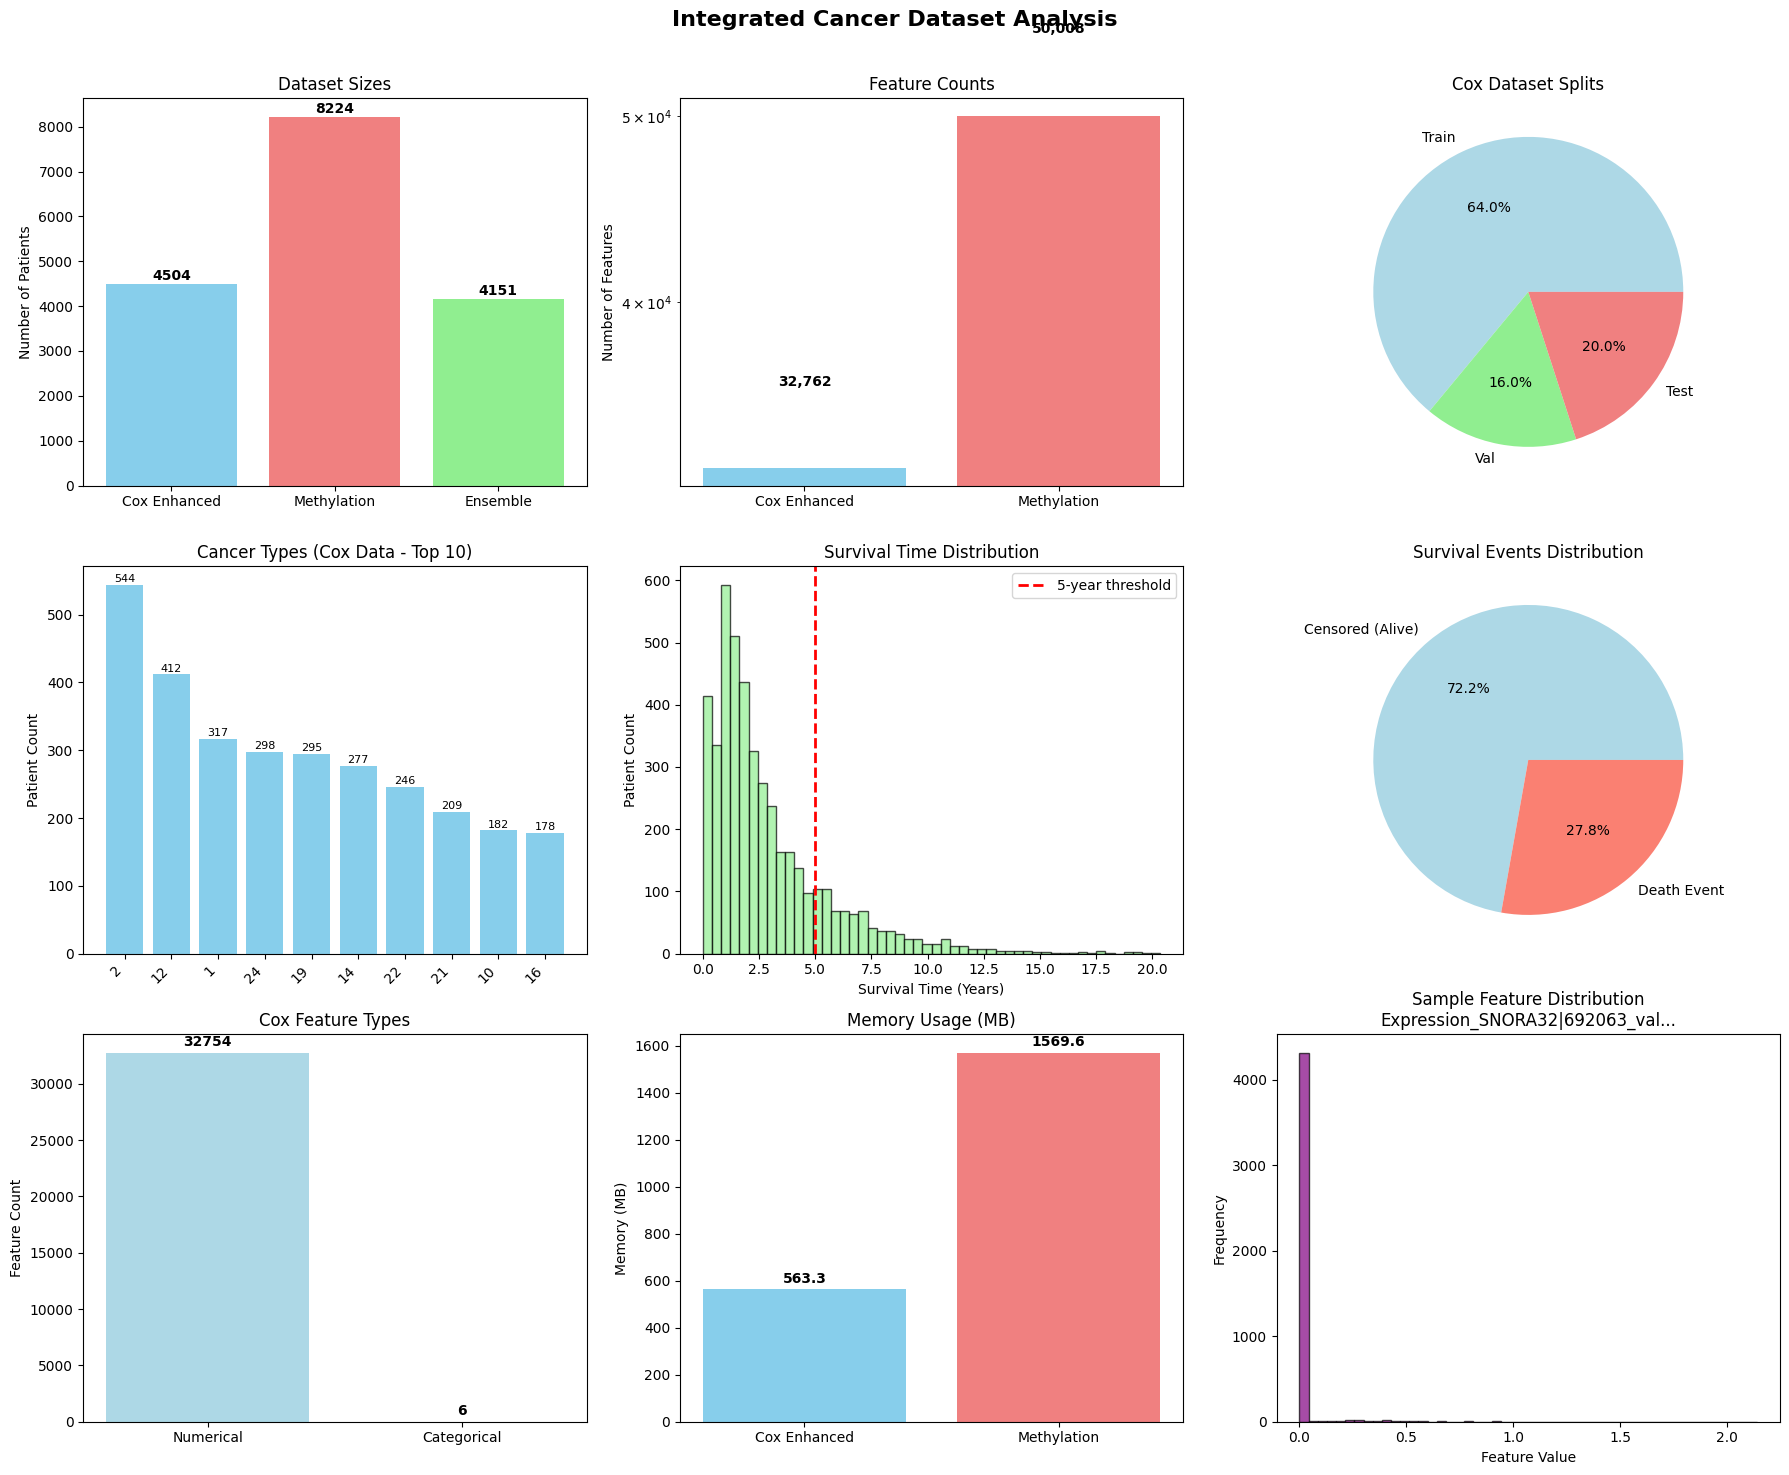


📊 DETAILED DATA STATISTICS

🎯 Cox-Enhanced Dataset:
  Shape: (4504, 32762)
  Memory usage: 563.3 MB
  Survival time (days) - Mean: 1062.8, Median: 728.0
  Cancer types: 29
  Split distribution by cancer type (top 5):
    2: Train=357, Val=88, Test=99
    12: Train=282, Val=58, Test=72
    1: Train=199, Val=44, Test=74
    24: Train=187, Val=47, Test=64
    19: Train=197, Val=42, Test=56

🧬 Methylation Dataset:
  Shape: (8224, 50008)
  Memory usage: 1569.6 MB
  Sample methylation values (first 5 probes):
    Mean range: 0.511 - 63.498
    Std range: 0.500 - 46.886

🤝 Ensemble Capability:
  Common patients: 4151
  Ensemble splits:
    Train: 2656
    Val: 664
    Test: 831

✅ Data validation completed!


In [20]:
def visualize_integrated_data(cox_data, methylation_data, cox_splits, methylation_splits):
    """
    Create comprehensive visualization of integrated datasets
    """
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Integrated Cancer Dataset Analysis', fontsize=16, fontweight='bold')
    
    # 1. Dataset sizes comparison
    ax = axes[0, 0]
    dataset_sizes = {
        'Cox Enhanced': len(cox_data) if not cox_data.empty else 0,
        'Methylation': len(methylation_data) if not methylation_data.empty else 0,
        'Ensemble': len(ensemble_patient_list)
    }
    
    bars = ax.bar(dataset_sizes.keys(), dataset_sizes.values(), 
                  color=['skyblue', 'lightcoral', 'lightgreen'])
    ax.set_title('Dataset Sizes')
    ax.set_ylabel('Number of Patients')
    
    # Add value labels on bars
    for bar, value in zip(bars, dataset_sizes.values()):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                   str(value), ha='center', va='bottom', fontweight='bold')
    
    # 2. Feature counts comparison
    ax = axes[0, 1]
    feature_counts = {
        'Cox Enhanced': cox_data.shape[1] if not cox_data.empty else 0,
        'Methylation': methylation_data.shape[1] if not methylation_data.empty else 0
    }
    
    bars = ax.bar(feature_counts.keys(), feature_counts.values(), 
                  color=['skyblue', 'lightcoral'])
    ax.set_title('Feature Counts')
    ax.set_ylabel('Number of Features')
    ax.set_yscale('log')
    
    # Add value labels
    for bar, value in zip(bars, feature_counts.values()):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
                   f'{value:,}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Data splits visualization (Cox)
    ax = axes[0, 2]
    if cox_splits['train']:  # If Cox splits exist
        split_sizes = [len(cox_splits['train']), len(cox_splits['val']), len(cox_splits['test'])]
        ax.pie(split_sizes, labels=['Train', 'Val', 'Test'], autopct='%1.1f%%', 
               colors=['lightblue', 'lightgreen', 'lightcoral'])
        ax.set_title('Cox Dataset Splits')
    else:
        ax.text(0.5, 0.5, 'No Cox Data\nAvailable', ha='center', va='center', 
               transform=ax.transAxes, fontsize=12)
        ax.set_title('Cox Dataset Splits')
    
    # 4. Cancer type distribution (Cox data)
    ax = axes[1, 0]
    if not cox_data.empty and 'acronym' in cox_data.columns:
        cancer_counts = cox_data['acronym'].value_counts().head(10)
        bars = ax.bar(range(len(cancer_counts)), cancer_counts.values, color='skyblue')
        ax.set_xticks(range(len(cancer_counts)))
        ax.set_xticklabels(cancer_counts.index, rotation=45, ha='right')
        ax.set_title('Cancer Types (Cox Data - Top 10)')
        ax.set_ylabel('Patient Count')
        
        # Add value labels
        for bar, value in zip(bars, cancer_counts.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   str(value), ha='center', va='bottom', fontsize=8)
    else:
        ax.text(0.5, 0.5, 'No Cancer Type\nData Available', ha='center', va='center',
               transform=ax.transAxes)
        ax.set_title('Cancer Types (Cox Data)')
    
    # 5. Survival time distribution
    ax = axes[1, 1]
    if not cox_data.empty and 'survival_time_clean' in cox_data.columns:
        survival_times = cox_data['survival_time_clean'] / 365.25  # Convert to years
        ax.hist(survival_times, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        ax.axvline(x=5, color='red', linestyle='--', linewidth=2, label='5-year threshold')
        ax.set_title('Survival Time Distribution')
        ax.set_xlabel('Survival Time (Years)')
        ax.set_ylabel('Patient Count')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No Survival\nData Available', ha='center', va='center',
               transform=ax.transAxes)
        ax.set_title('Survival Time Distribution')
    
    # 6. Survival events distribution
    ax = axes[1, 2]
    if not cox_data.empty and 'survival_event_clean' in cox_data.columns:
        event_counts = cox_data['survival_event_clean'].value_counts()
        labels = ['Censored (Alive)', 'Death Event']
        ax.pie(event_counts.values, labels=labels, autopct='%1.1f%%', 
               colors=['lightblue', 'salmon'])
        ax.set_title('Survival Events Distribution')
    else:
        ax.text(0.5, 0.5, 'No Survival\nEvents Available', ha='center', va='center',
               transform=ax.transAxes)
        ax.set_title('Survival Events Distribution')
    
    # 7. Feature type breakdown (Cox)
    ax = axes[2, 0]
    if not cox_data.empty and cox_feature_info:
        feature_type_counts = {
            'Numerical': len(cox_feature_info.get('numerical_features', [])),
            'Categorical': len(cox_feature_info.get('categorical_features', []))
        }
        
        ax.bar(feature_type_counts.keys(), feature_type_counts.values(), 
               color=['lightblue', 'orange'])
        ax.set_title('Cox Feature Types')
        ax.set_ylabel('Feature Count')
        
        # Add value labels
        for i, (key, value) in enumerate(feature_type_counts.items()):
            ax.text(i, value + max(feature_type_counts.values()) * 0.01, 
                   str(value), ha='center', va='bottom', fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No Cox Feature\nInfo Available', ha='center', va='center',
               transform=ax.transAxes)
        ax.set_title('Cox Feature Types')
    
    # 8. Memory usage comparison
    ax = axes[2, 1]
    memory_usage = {}
    
    if not cox_data.empty:
        cox_memory = cox_data.memory_usage(deep=True).sum() / 1024**2  # MB
        memory_usage['Cox Enhanced'] = cox_memory
    
    if not methylation_data.empty:
        meth_memory = methylation_data.memory_usage(deep=True).sum() / 1024**2  # MB
        memory_usage['Methylation'] = meth_memory
    
    if memory_usage:
        bars = ax.bar(memory_usage.keys(), memory_usage.values(), 
                      color=['skyblue', 'lightcoral'])
        ax.set_title('Memory Usage (MB)')
        ax.set_ylabel('Memory (MB)')
        
        # Add value labels
        for bar, value in zip(bars, memory_usage.values()):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(memory_usage.values()) * 0.01, 
                   f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No Memory\nInfo Available', ha='center', va='center',
               transform=ax.transAxes)
        ax.set_title('Memory Usage (MB)')
    
    # 9. Sample feature distribution (first numerical feature)
    ax = axes[2, 2]
    if not cox_data.empty and cox_feature_info and cox_feature_info.get('numerical_features'):
        # Get first numerical feature that's not survival-related
        numerical_features = [f for f in cox_feature_info['numerical_features'] 
                            if 'survival' not in f.lower()]
        
        if numerical_features:
            sample_feature = numerical_features[0]
            feature_values = cox_data[sample_feature].dropna()
            
            ax.hist(feature_values, bins=50, alpha=0.7, color='purple', edgecolor='black')
            ax.set_title(f'Sample Feature Distribution\n{sample_feature[:30]}...')
            ax.set_xlabel('Feature Value')
            ax.set_ylabel('Frequency')
        else:
            ax.text(0.5, 0.5, 'No Numerical\nFeatures Available', ha='center', va='center',
                   transform=ax.transAxes)
            ax.set_title('Sample Feature Distribution')
    else:
        ax.text(0.5, 0.5, 'No Feature\nData Available', ha='center', va='center',
               transform=ax.transAxes)
        ax.set_title('Sample Feature Distribution')
    
    plt.tight_layout()
    plt.show()

print("=" * 60)
print("DATA VALIDATION AND VISUALIZATION")
print("=" * 60)

# Create comprehensive visualization
visualize_integrated_data(cox_processed, methylation_processed, cox_splits, methylation_splits)

# Print detailed statistics
print(f"\n📊 DETAILED DATA STATISTICS")
print(f"=" * 40)

if not cox_processed.empty:
    print(f"\n🎯 Cox-Enhanced Dataset:")
    print(f"  Shape: {cox_processed.shape}")
    print(f"  Memory usage: {cox_processed.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    if 'survival_time_clean' in cox_processed.columns:
        survival_stats = cox_processed['survival_time_clean'].describe()
        print(f"  Survival time (days) - Mean: {survival_stats['mean']:.1f}, Median: {survival_stats['50%']:.1f}")
    
    if 'acronym' in cox_processed.columns:
        cancer_types = cox_processed['acronym'].nunique()
        print(f"  Cancer types: {cancer_types}")
        
        # Show split statistics per cancer type
        print(f"  Split distribution by cancer type (top 5):")
        top_cancers = cox_processed['acronym'].value_counts().head(5)
        for cancer, total in top_cancers.items():
            train_count = sum(1 for p in cox_splits['train'] if p in cox_processed.index and cox_processed.loc[p, 'acronym'] == cancer)
            val_count = sum(1 for p in cox_splits['val'] if p in cox_processed.index and cox_processed.loc[p, 'acronym'] == cancer)
            test_count = sum(1 for p in cox_splits['test'] if p in cox_processed.index and cox_processed.loc[p, 'acronym'] == cancer)
            print(f"    {cancer}: Train={train_count}, Val={val_count}, Test={test_count}")

if not methylation_processed.empty:
    print(f"\n🧬 Methylation Dataset:")
    print(f"  Shape: {methylation_processed.shape}")
    print(f"  Memory usage: {methylation_processed.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Sample methylation statistics
    numerical_cols = methylation_processed.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 10:  # Skip survival columns for methylation stats
        meth_cols = [c for c in numerical_cols if 'survival' not in c.lower() and 'age' not in c.lower()]
        if meth_cols:
            sample_stats = methylation_processed[meth_cols[:5]].describe()
            print(f"  Sample methylation values (first 5 probes):")
            print(f"    Mean range: {sample_stats.loc['mean'].min():.3f} - {sample_stats.loc['mean'].max():.3f}")
            print(f"    Std range: {sample_stats.loc['std'].min():.3f} - {sample_stats.loc['std'].max():.3f}")

print(f"\n🤝 Ensemble Capability:")
print(f"  Common patients: {len(ensemble_patient_list)}")
if ensemble_patient_list:
    print(f"  Ensemble splits:")
    print(f"    Train: {len(ensemble_splits['train'])}")
    print(f"    Val: {len(ensemble_splits['val'])}")
    print(f"    Test: {len(ensemble_splits['test'])}")

print(f"\n✅ Data validation completed!")

## 9. Save Final Results

In [21]:
print("=" * 60)
print("SAVING FINAL INTEGRATED DATASETS")
print("=" * 60)

# Save Cox-enhanced integrated table
if not cox_processed.empty:
    cox_file = DATA_PROCESSED_PATH / 'integrated_table_cox.parquet'
    cox_processed.to_parquet(cox_file)
    print(f"✅ Cox-enhanced table saved: {cox_file}")
    print(f"   Shape: {cox_processed.shape}")
    print(f"   Size: {cox_file.stat().st_size / 1024**2:.1f} MB")
    
    # Save Cox feature info
    cox_feature_file = DATA_PROCESSED_PATH / 'cox_feature_info.json'
    with open(cox_feature_file, 'w') as f:
        # Convert any non-serializable objects
        serializable_info = {}
        for key, value in cox_feature_info.items():
            if key == 'categorical_encoders':
                # Convert LabelEncoders to class lists
                serializable_info[key] = {
                    encoder_name: encoder.classes_.tolist() 
                    for encoder_name, encoder in value.items()
                }
            else:
                serializable_info[key] = value
        
        json.dump(serializable_info, f, indent=2)
    print(f"✅ Cox feature info saved: {cox_feature_file}")
else:
    print(f"❌ Cox-enhanced table: No data to save")

# Save methylation integrated table
if not methylation_processed.empty:
    methylation_file = DATA_PROCESSED_PATH / 'methylation_table.parquet'
    methylation_processed.to_parquet(methylation_file)
    print(f"✅ Methylation table saved: {methylation_file}")
    print(f"   Shape: {methylation_processed.shape}")
    print(f"   Size: {methylation_file.stat().st_size / 1024**2:.1f} MB")
    
    # Save methylation feature info
    meth_feature_file = DATA_PROCESSED_PATH / 'methylation_feature_info.json'
    with open(meth_feature_file, 'w') as f:
        # Convert any non-serializable objects
        serializable_info = {}
        for key, value in methylation_feature_info.items():
            if key == 'categorical_encoders':
                serializable_info[key] = {
                    encoder_name: encoder.classes_.tolist() 
                    for encoder_name, encoder in value.items()
                }
            else:
                serializable_info[key] = value
        
        json.dump(serializable_info, f, indent=2)
    print(f"✅ Methylation feature info saved: {meth_feature_file}")
else:
    print(f"❌ Methylation table: No data to save")

# Save data splits
all_splits = {
    'cox_enhanced': cox_splits,
    'methylation': methylation_splits,
    'ensemble': ensemble_splits
}

splits_file = DATA_PROCESSED_PATH / 'train_val_test_splits.json'
with open(splits_file, 'w') as f:
    json.dump(all_splits, f, indent=2)
print(f"✅ Data splits saved: {splits_file}")

# Save dataset summary
dataset_summary = {
    'creation_timestamp': pd.Timestamp.now().isoformat(),
    'datasets': {
        'cox_enhanced': {
            'patients': len(cox_processed) if not cox_processed.empty else 0,
            'features': cox_processed.shape[1] if not cox_processed.empty else 0,
            'memory_mb': cox_processed.memory_usage(deep=True).sum() / 1024**2 if not cox_processed.empty else 0,
            'train_patients': len(cox_splits['train']),
            'val_patients': len(cox_splits['val']),
            'test_patients': len(cox_splits['test'])
        },
        'methylation': {
            'patients': len(methylation_processed) if not methylation_processed.empty else 0,
            'features': methylation_processed.shape[1] if not methylation_processed.empty else 0,
            'memory_mb': methylation_processed.memory_usage(deep=True).sum() / 1024**2 if not methylation_processed.empty else 0,
            'train_patients': len(methylation_splits['train']),
            'val_patients': len(methylation_splits['val']),
            'test_patients': len(methylation_splits['test'])
        },
        'ensemble': {
            'common_patients': len(ensemble_patient_list),
            'train_patients': len(ensemble_splits['train']),
            'val_patients': len(ensemble_splits['val']),
            'test_patients': len(ensemble_splits['test'])
        }
    },
    'feature_engineering': {
        'cox_coefficient_pairs': 'Applied to Expression, CNV, microRNA, RPPA, Mutations',
        'methylation_processing': 'Separate TabTransformer without Cox coefficients',
        'normalization': 'StandardScaler applied to numerical features',
        'categorical_encoding': 'LabelEncoder applied to categorical features'
    }
}

summary_file = RESULTS_PATH / 'integrated_dataset_summary.json'
with open(summary_file, 'w') as f:
    json.dump(dataset_summary, f, indent=2)
print(f"✅ Dataset summary saved: {summary_file}")

print(f"\n=" * 60)
print("PHASE 1-4: INTEGRATED DATASET CREATION COMPLETED!")
print(f"=" * 60)

print(f"\n📋 Final Output Summary:")
print(f"\n🎯 Cox-Enhanced TabTransformer Dataset:")
if not cox_processed.empty:
    print(f"   📊 Patients: {len(cox_processed):,}")
    print(f"   🧬 Features: {cox_processed.shape[1]:,} ([value, cox_coef] pairs)")
    print(f"   📂 File: integrated_table_cox.parquet")
    print(f"   🔄 Splits: Train={len(cox_splits['train'])}, Val={len(cox_splits['val'])}, Test={len(cox_splits['test'])}")
else:
    print(f"   ❌ No data available")

print(f"\n🧬 Methylation TabTransformer Dataset:")
if not methylation_processed.empty:
    print(f"   📊 Patients: {len(methylation_processed):,}")
    print(f"   🧬 Features: {methylation_processed.shape[1]:,} (beta values)")
    print(f"   📂 File: methylation_table.parquet")
    print(f"   🔄 Splits: Train={len(methylation_splits['train'])}, Val={len(methylation_splits['val'])}, Test={len(methylation_splits['test'])}")
else:
    print(f"   ❌ No data available")

print(f"\n🤝 Ensemble Capability:")
print(f"   📊 Common patients: {len(ensemble_patient_list):,}")
print(f"   🔄 Splits: Train={len(ensemble_splits['train'])}, Val={len(ensemble_splits['val'])}, Test={len(ensemble_splits['test'])}")

print(f"\n🔧 PyTorch Dataset Classes:")
print(f"   📂 File: src/preprocessing/integrated_dataset.py")
print(f"   🏗️  Classes: IntegratedCancerDataset, MultiModalCancerDataset")

print(f"\n📁 Key Files Created:")
print(f"   📊 integrated_table_cox.parquet")
print(f"   🧬 methylation_table.parquet")
print(f"   📋 train_val_test_splits.json")
print(f"   🏗️  src/preprocessing/integrated_dataset.py")
print(f"   📈 integrated_dataset_summary.json")

print(f"\n✅ Ready for Phase 2: TabTransformer model development!")
print(f"\n🎯 Next Steps:")
print(f"   1. Implement TabTransformer for Cox-enhanced data")
print(f"   2. Implement TabTransformer for methylation data")
print(f"   3. Train and evaluate both models")
print(f"   4. Develop ensemble prediction strategy")

SAVING FINAL INTEGRATED DATASETS
✅ Cox-enhanced table saved: ../data/processed/integrated_table_cox.parquet
   Shape: (4504, 32762)
   Size: 175.1 MB
✅ Cox feature info saved: ../data/processed/cox_feature_info.json
✅ Methylation table saved: ../data/processed/methylation_table.parquet
   Shape: (8224, 50008)
   Size: 2227.9 MB
✅ Methylation feature info saved: ../data/processed/methylation_feature_info.json
✅ Data splits saved: ../data/processed/train_val_test_splits.json
✅ Dataset summary saved: ../results/integrated_dataset_summary.json

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
PHASE 1-4: INTEGRATED DATASET CREATION COMPLETED!

📋 Final Output Summary:

🎯 Cox-Enhanced TabTransformer Dataset:
   📊 Patients: 4,504
   🧬 Features: 32,762 ([value, cox_coef] pairs)
   📂 File: integrated_table_cox.parquet
   🔄 Splits: Train=2882, Val=721, Test=901

🧬 Methylation TabTransformer Dataset:
   📊 Patients: 8,224
   🧬 F